In [1]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import plot_model
import shap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Adding a channel dimension to the images
train_images, test_images = np.expand_dims(a=train_images, axis=-1) / 255.0, np.expand_dims(a=test_images, axis=-1) / 255.0

# Obtaining possible labels from the dataset
labels = np.unique(ar=test_labels)

# Converting labels to categoricals
train_labels, test_labels = tf.keras.utils.to_categorical(y=train_labels), tf.keras.utils.to_categorical(y=test_labels)

In [3]:
# Function for creating TF Keras model
def create_model():
    # Input layer
    input_layer = Input(shape=(28, 28, 1))

    # First Conv2D + MaxPool2D block
    x = Conv2D(filters=16,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(input_layer)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Second Conv2D + MaxPool2D block
    x = Conv2D(filters=32,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    
    # Third Conv2D + MaxPool2D block
    x = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation="relu",
               padding="same")(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Global Average Pooling and Dense output layers
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(units=10, 
                         activation="softmax")(x)

    # Returning the model
    return Model(inputs=input_layer, 
                 outputs=output_layer)

In [4]:
# Creating the model
model = create_model()

# Compiling the model
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

# Training the model
history = model.fit(x=train_images, y=train_labels,
                    batch_size=128,
                    epochs=5,
                    validation_data=(test_images, test_labels))

Epoch 1/5
469/469 [==============================] - 6s 7ms/step - loss: 0.6678 - accuracy: 0.7944 - val_loss: 0.2399 - val_accuracy: 0.9269
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.2104 - accuracy: 0.9376 - val_loss: 0.1694 - val_accuracy: 0.9490
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1540 - accuracy: 0.9535 - val_loss: 0.1275 - val_accuracy: 0.9610
Epoch 4/5
469/469 [==============================] - 3s 7ms/step - loss: 0.1297 - accuracy: 0.9610 - val_loss: 0.1044 - val_accuracy: 0.9693
Epoch 5/5
469/469 [==============================] - 3s 6ms/step - loss: 0.1098 - accuracy: 0.9665 - val_loss: 0.0888 - val_accuracy: 0.9728


In [5]:
# Saving our model
model.save(filepath="model.h5")

In [6]:
# Creating a list for image indices
indices = []

# Obtaining the index of the first image of each label
for label in labels:
    label_index = np.where(np.argmax(a=test_labels, axis=1)==label)[0][0]
    indices.append(label_index)
    
imgs_to_explain = test_images[indices]

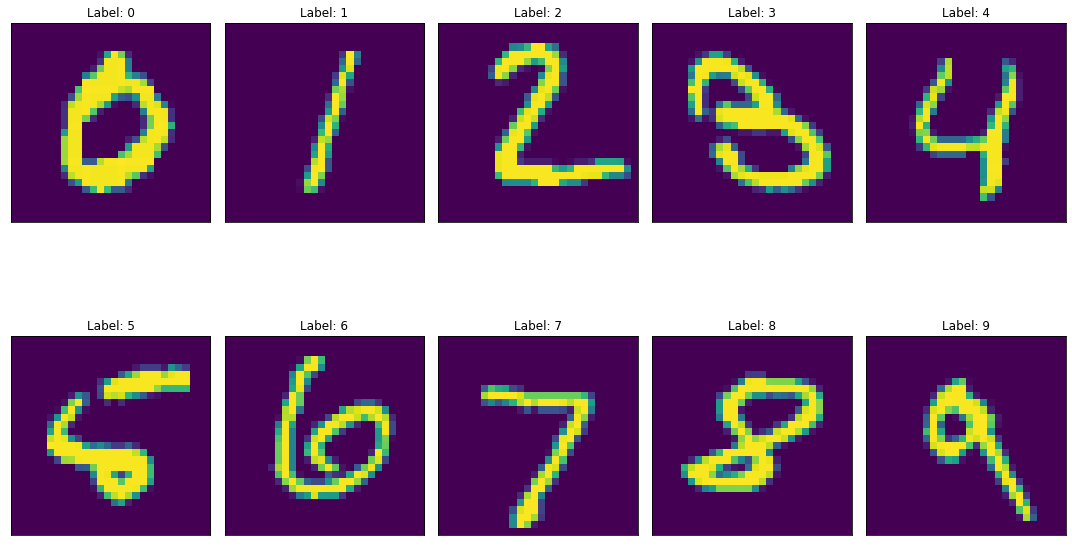

In [7]:
# Confirming that the indices are correct
# Creating a figure
plt.figure(figsize=(15, 10))

# Setting the number of rows and columns
rows, cols = 2, 5

# Iterating over the total number of spots in the figure
for i in range(rows * cols):
    # Creating a subplot
    plt.subplot(rows, cols, i + 1)    
    
    # Showing current image
    plt.imshow(X=test_images[indices[i]])    
    
    # Showing label corresponding to image
    plt.title(label=f"Label: {np.argmax(test_labels[indices[i]])}")
    
    # Hiding x and y ticks
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])  

# Using space available in the figure efficiently
plt.tight_layout()

# Showing the plot
plt.show()

In [8]:
# Creating an image masker
masker = shap.maskers.Image(mask_value="blur(128, 128)", 
                            shape=test_images[0].shape)

# Creating an explainer object
explainer = shap.Explainer(model=model.predict, 
                           masker=masker, 
                           algorithm="auto", 
                           output_names=labels.astype(str))

In [9]:
# Function for calculating and plotting SHAP values
def plot_shap_values(imgs_to_explain, max_evals):
    # Calculating shap values for our images
    shap_values = explainer(imgs_to_explain,
                            max_evals=max_evals,
                            outputs=shap.Explanation.argsort.flip[:3])    

    # Plotting shap values
    shap.image_plot(shap_values=shap_values, 
                    show=False)    

Partition explainer: 11it [00:23,  3.91s/it]                                                                           


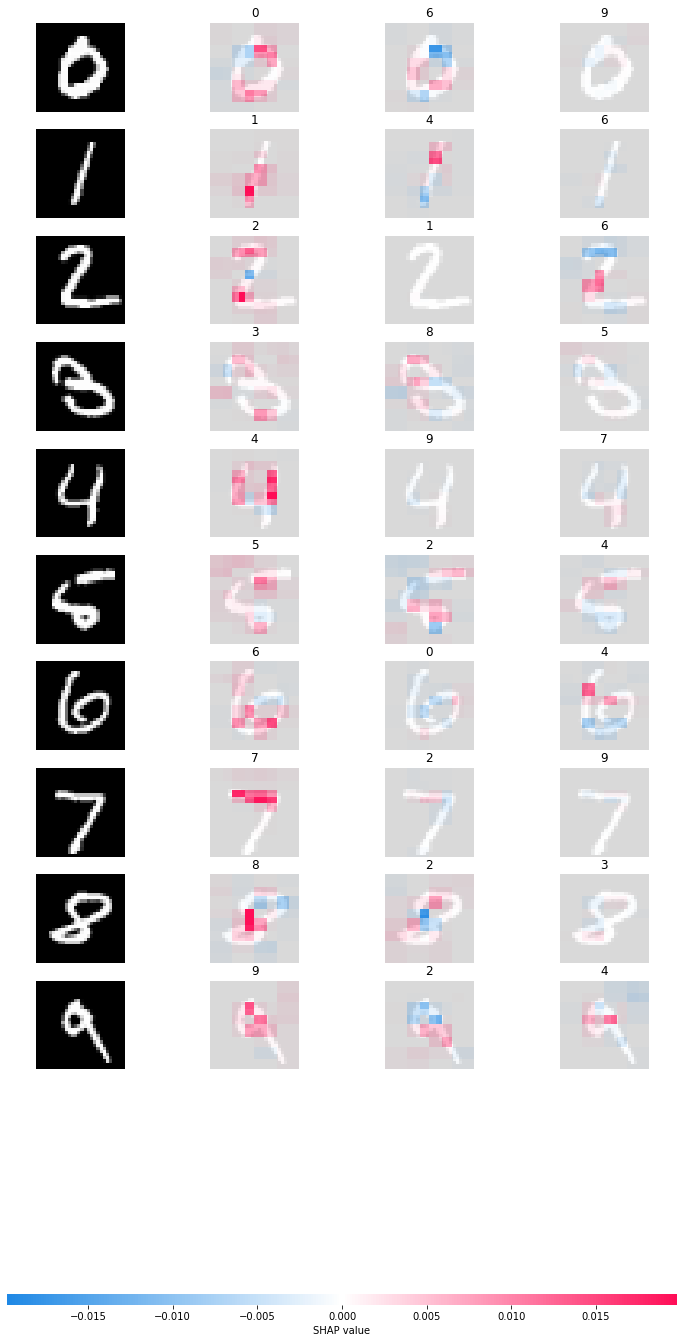

In [10]:
# Plotting SHAP values
plot_shap_values(imgs_to_explain=imgs_to_explain,
                 max_evals=1000)

Partition explainer: 11it [00:11,  5.78s/it]                                                                           
Partition explainer: 11it [00:22,  3.69s/it]                                                                           


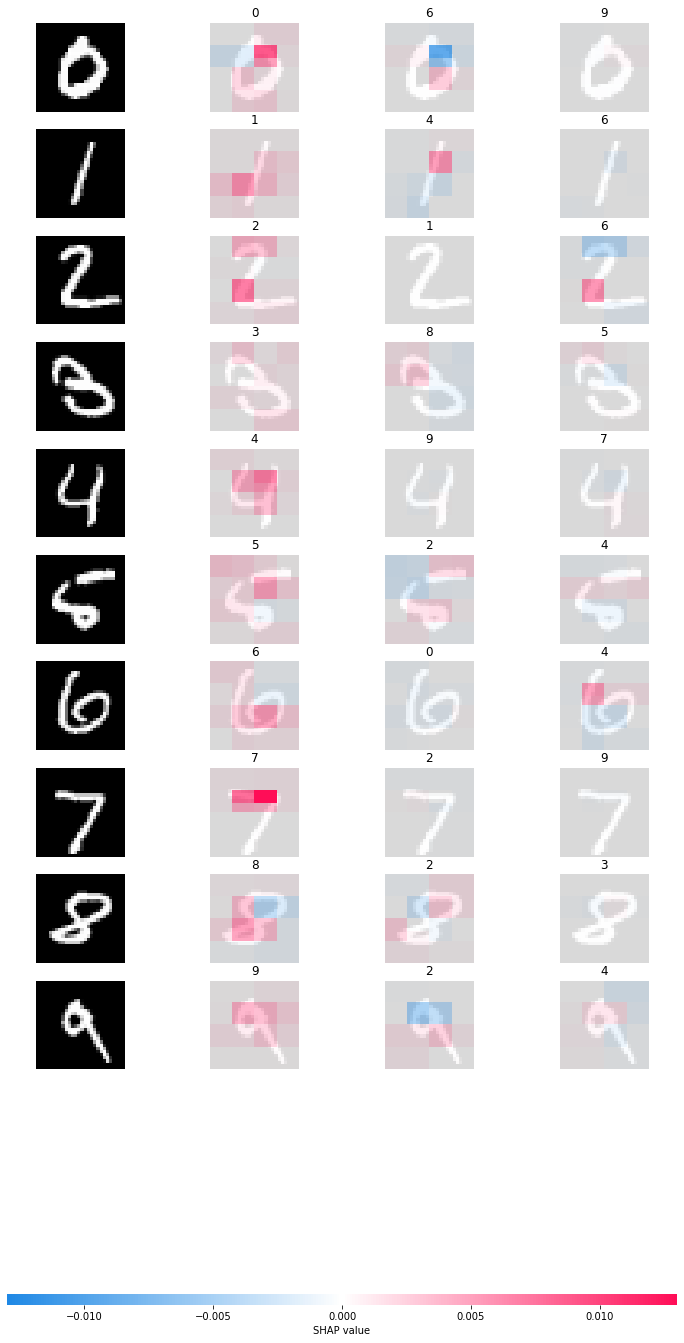

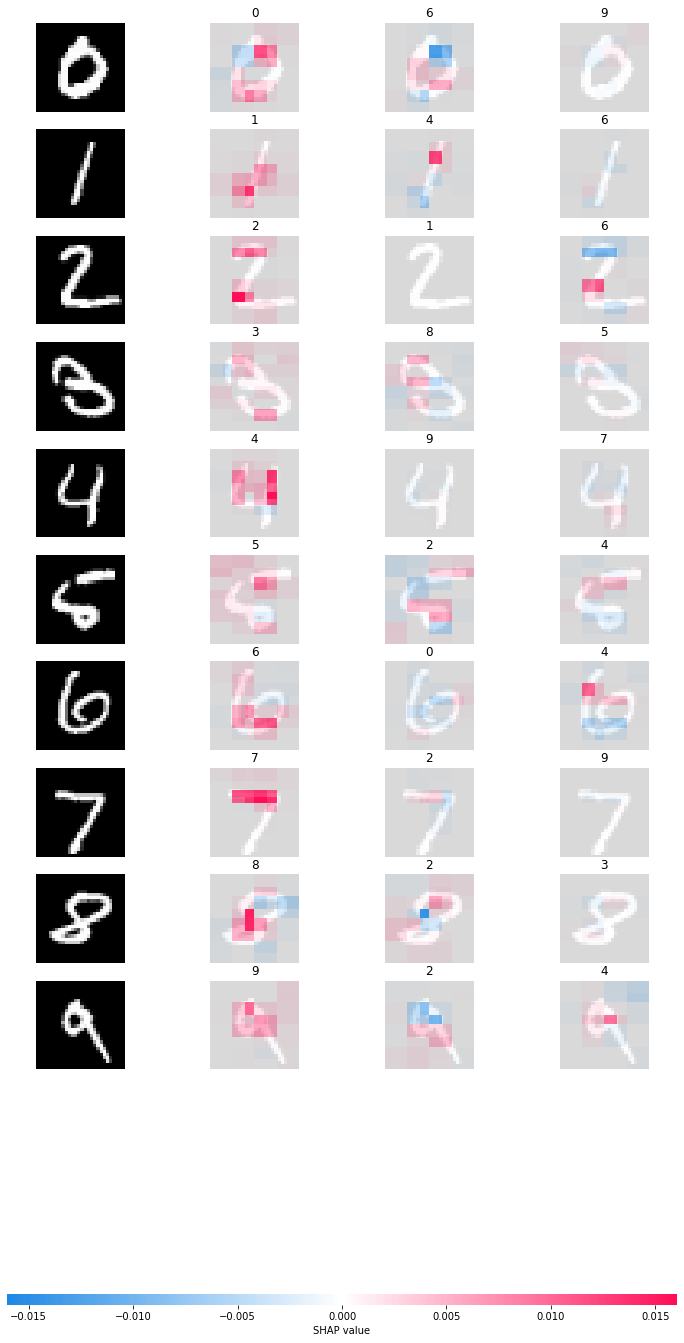

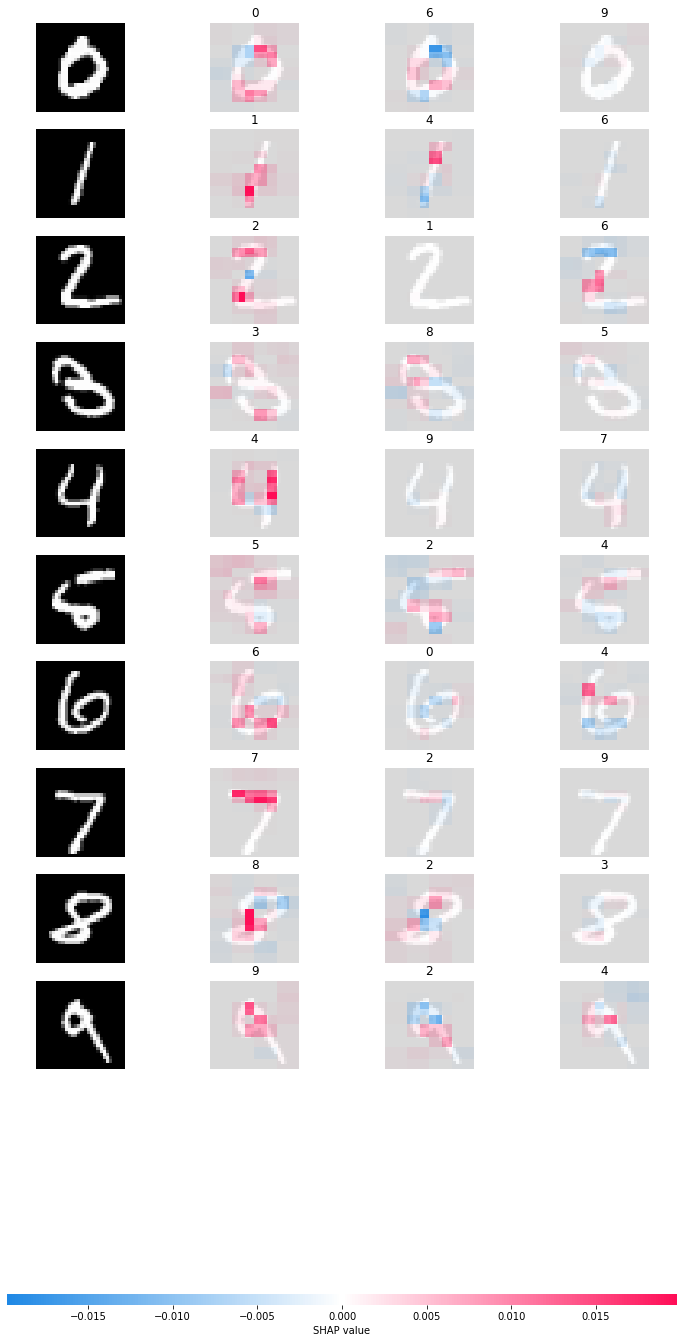

In [11]:
# Choosing max evaluations to try
max_evals = [100, 500, 1000]

# Iterating over eval values
for max_eval in max_evals:
    # Plotting SHAP values
    plot_shap_values(imgs_to_explain=imgs_to_explain,
                     max_evals=max_eval)

### Using GradientExplainer

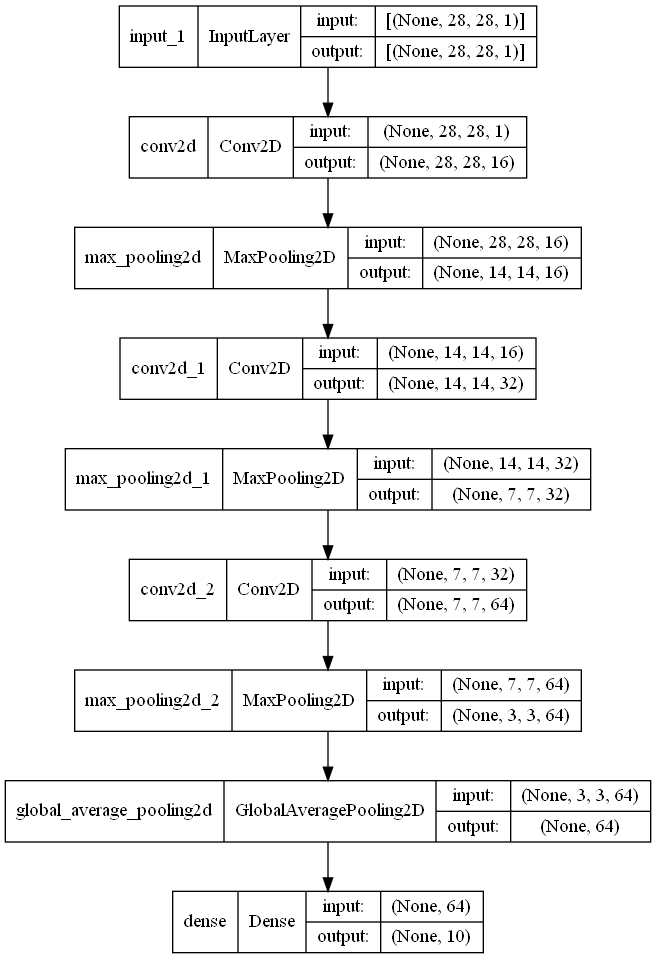

In [12]:
# Plotting the model
plot_model(model=model, 
           show_shapes=True)

In [13]:
# Creating a model that would produce processed images of necessary shape 
model_input = Model(inputs=model.layers[0].input, 
                    outputs=model.layers[2].output)

# Creating a model that has the layer that we are interested in as input
model_output = Model(inputs=model.layers[3].input, 
                     outputs=model.layers[-1].output)

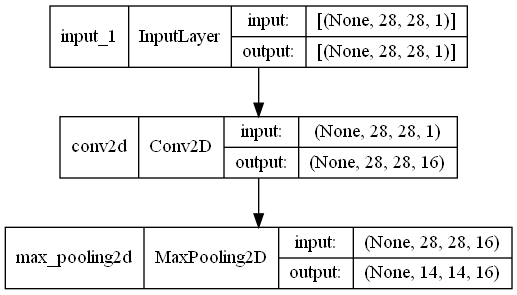

In [14]:
# Plotting the input model
plot_model(model=model_input, 
           show_shapes=True)

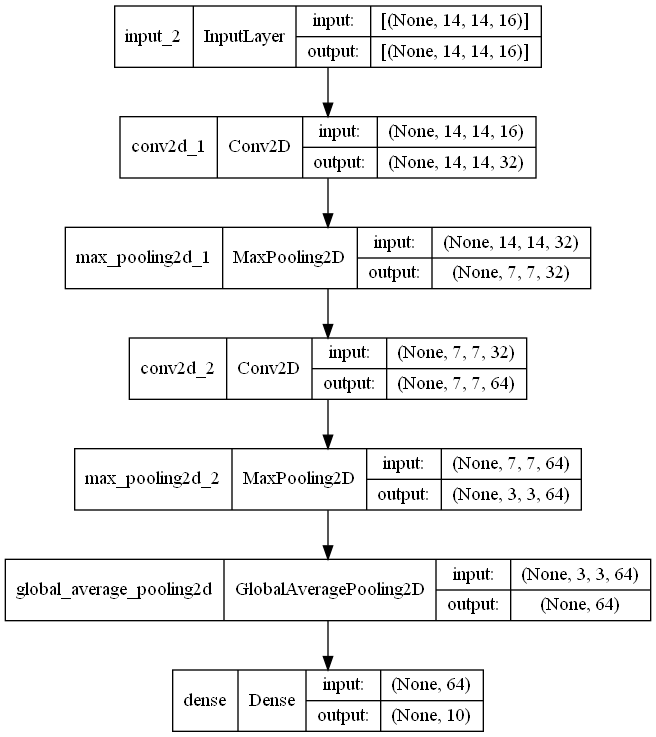

In [15]:
# Plotting the output model
plot_model(model=model_output, 
           show_shapes=True)

In [16]:
# Function for calculating and plotting SHAP values with GradientExplainer
def calculcate_plot_gradient_explainer(model_input, 
                                       model_output, 
                                       test_images, 
                                       imgs_to_explain):
    
    # Creating a GradientExplainer object
    gradient_explainer = shap.GradientExplainer(model=model_output, 
                                                data=model_input.predict(test_images))

    # Obtaining SHAP values and the indexes for model outputs
    shap_values, indexes = gradient_explainer.shap_values(X=model_input.predict(imgs_to_explain), 
                                                          ranked_outputs=3)

    # Plotting SHAP values
    shap.image_plot(shap_values=shap_values, 
                    pixel_values=imgs_to_explain, 
                    labels=indexes)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


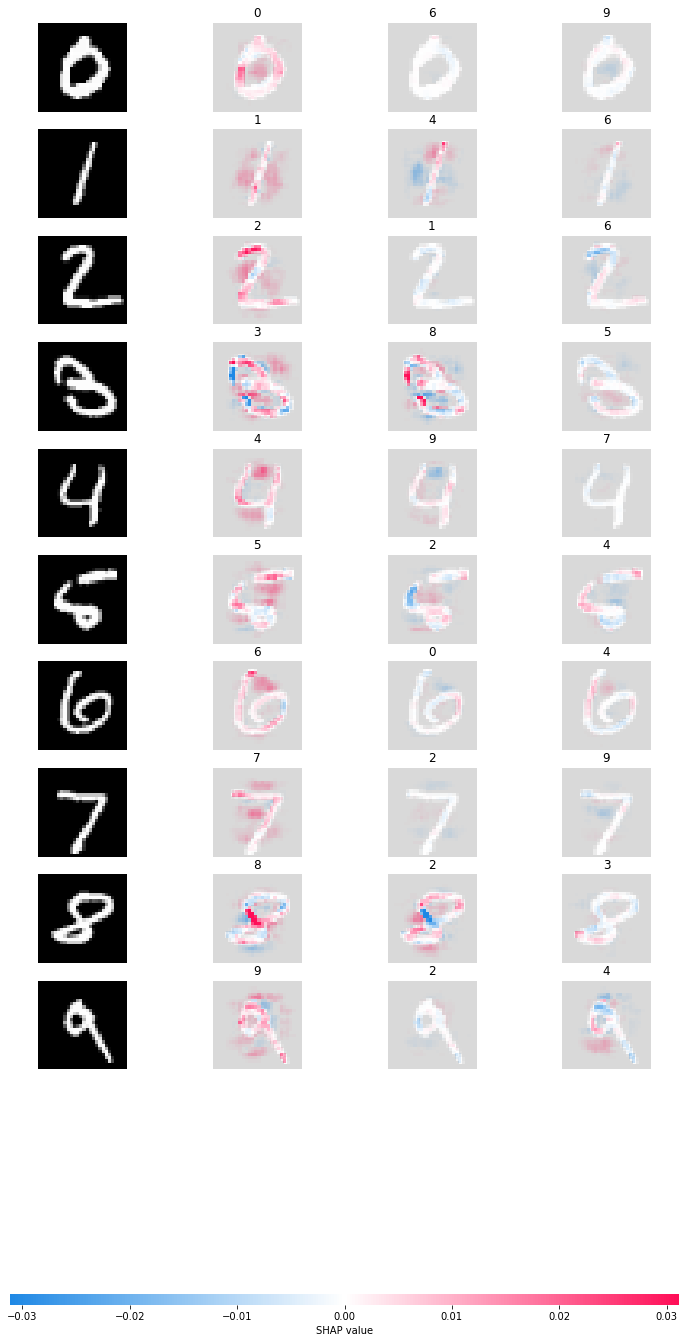

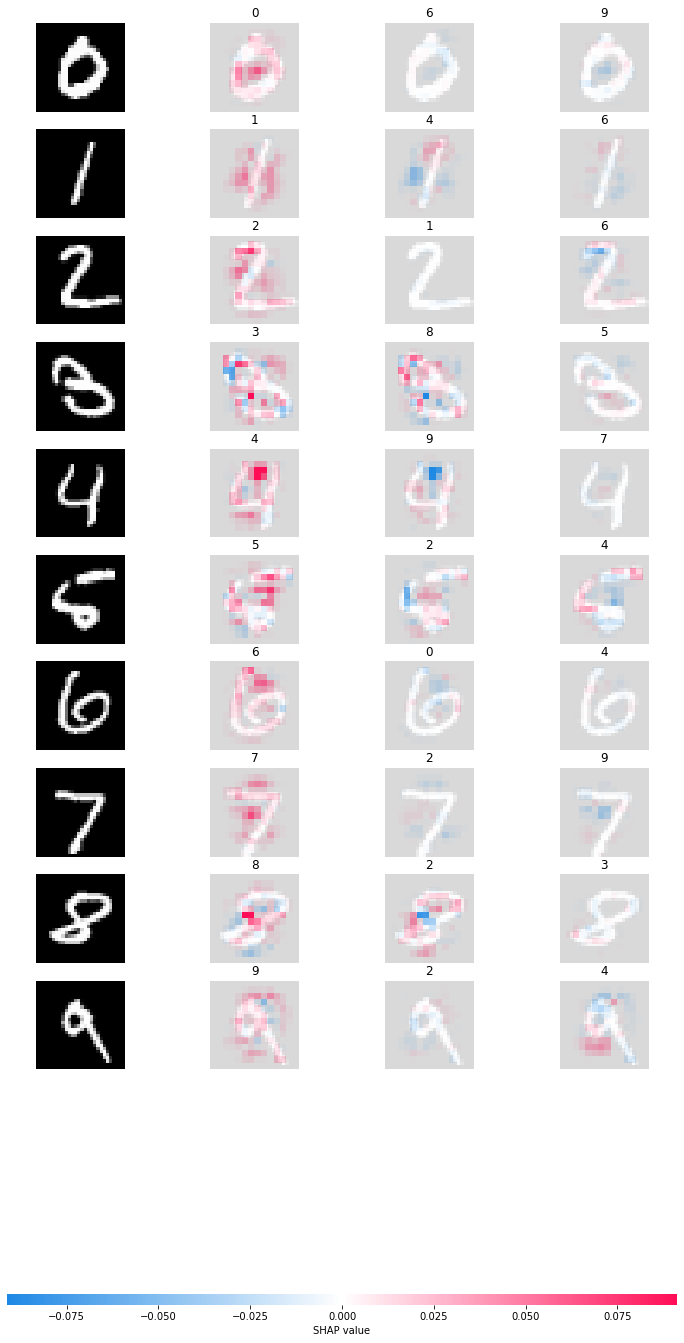

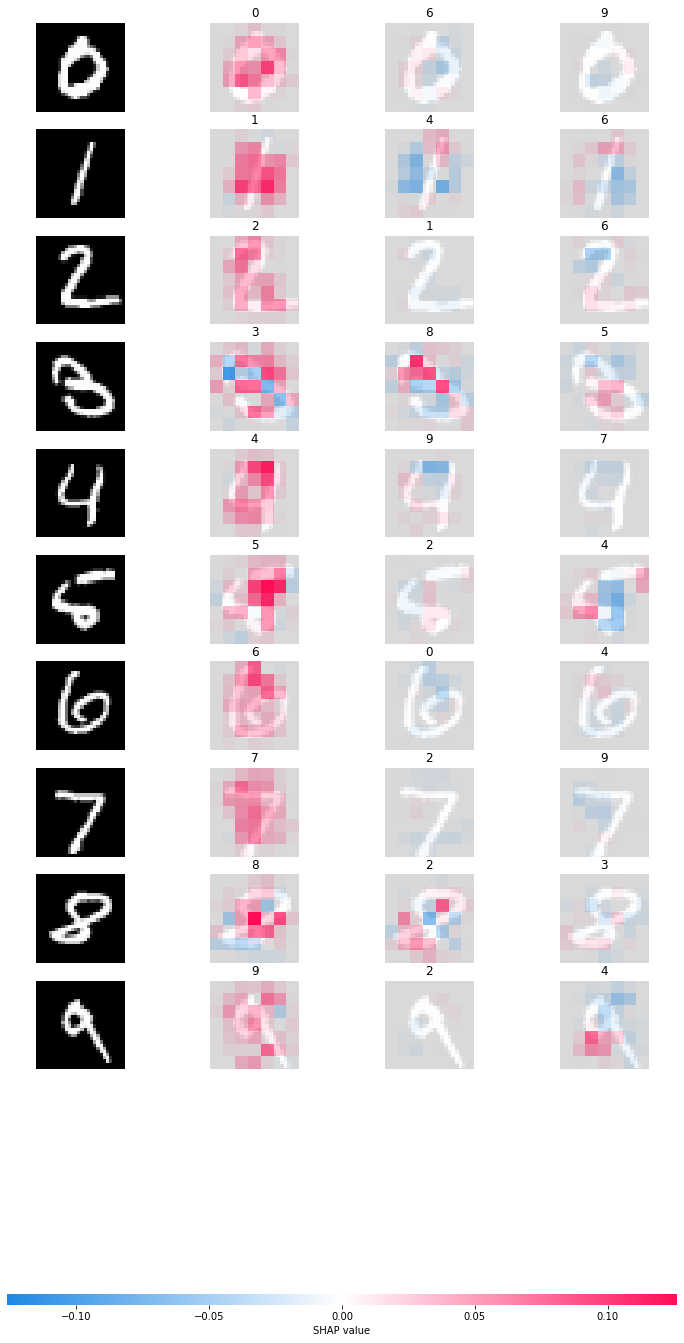

In [17]:
# Getting the indices of the conv layers in the model
conv_layer_indices = [i for i, layer in enumerate(model.layers) if "conv" in layer.name]

for layer_index in conv_layer_indices:
    # Creating a model that would produce inputs of necessary shape
    model_input = Model(inputs=model.layers[0].input, 
                        outputs=model.layers[layer_index - 1].output)
    
    # Creating a model that has the layer that we are interested in as input
    model_output = Model(inputs=model.layers[layer_index].input, 
                         outputs=model.layers[-1].output)
    
    calculcate_plot_gradient_explainer(model_input=model_input,
                                       model_output=model_output,
                                       test_images=test_images,
                                       imgs_to_explain=imgs_to_explain)

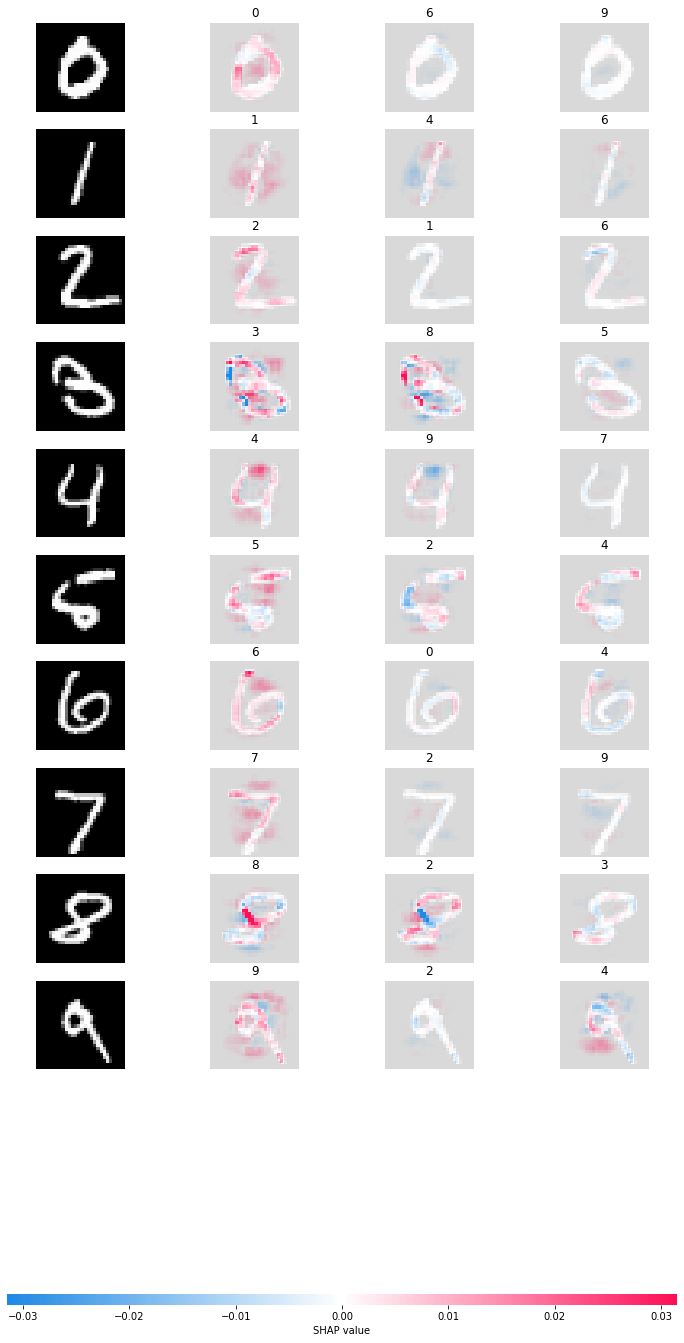

In [18]:
# Creating a GradientExplainer object
gradient_explainer = shap.GradientExplainer(model=model, 
                                            data=test_images)

# Obtaining SHAP values and the indexes for model outputs
shap_values, indexes = gradient_explainer.shap_values(imgs_to_explain,                                                    
                                                      ranked_outputs=3)

# Plotting SHAP values
shap.image_plot(shap_values=shap_values, 
                pixel_values=imgs_to_explain, 
                labels=indexes)

### Using DeepExplainer

In [19]:
# Disabling TF 2.x behavior
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [20]:
# Creating and loading a new model
model_v1 = create_model()
model_v1.load_weights(filepath="model.h5")

In [21]:
# Picking background data for the Deep Explainer
data = test_images[7500:]

# Creating a DeepExplainer object
deep_explainer = shap.DeepExplainer(model=model_v1, 
                                    data=data)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


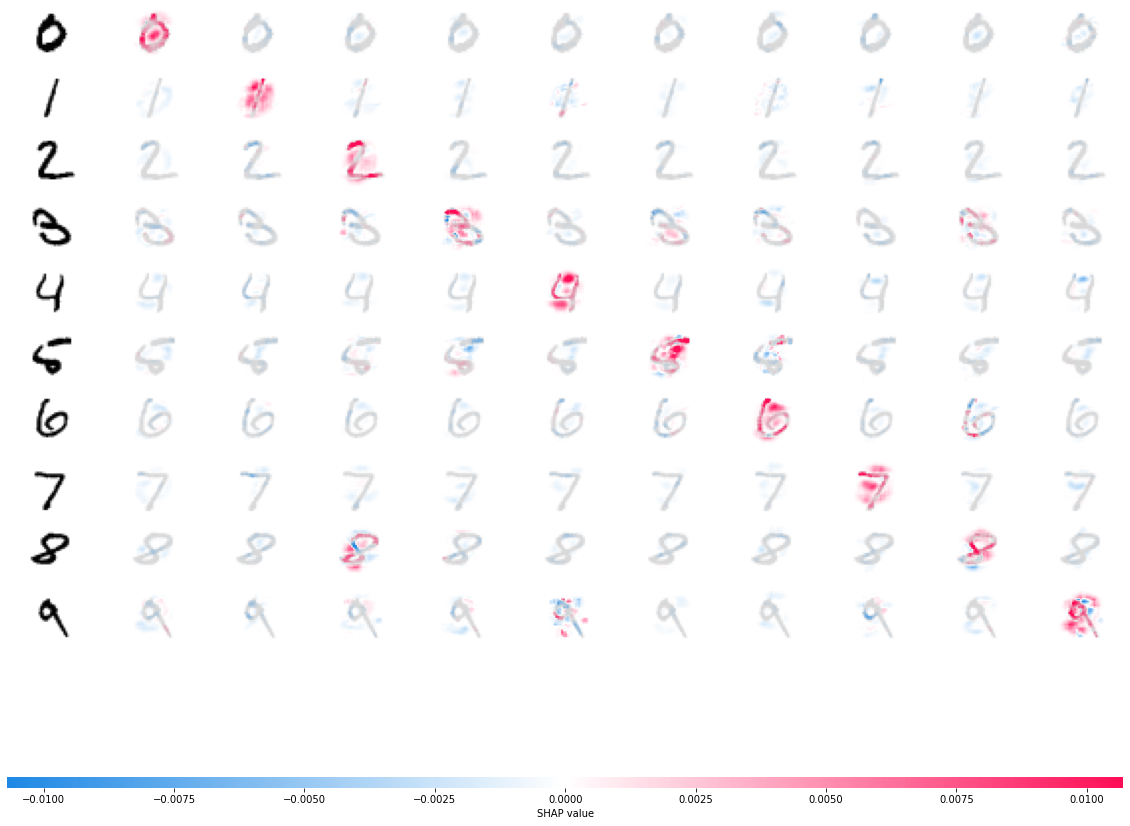

In [22]:
# Computing deep explainer values
shap_values = deep_explainer.shap_values(X=imgs_to_explain)

# Showing SHAP values
shap.image_plot(shap_values=shap_values, 
                pixel_values=-imgs_to_explain)